In [111]:
pip install nltk
pip install feedparser
pip install beautifulsoup4


In [112]:
import nltk
nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [121]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import requests
from bs4 import BeautifulSoup
import feedparser

def scrape_news_from_feed(feed_url):
    articles = []
    feed = feedparser.parse(feed_url)

    for entry in feed.entries:
        url = entry.link

        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            title = soup.find('title').get_text(strip=True) if soup.find('title') else "No title available"
            author = soup.find('meta', attrs={'name': 'author'})['content'] if soup.find('meta', attrs={'name': 'author'}) else "Unknown"
            publish_date = entry['published'] if entry['published'] else "Unknown"
            paragraphs = soup.find_all('p')
            content = "\n".join([para.get_text(strip=True) for para in paragraphs])

            polarity = analyze_sentiment(content)

            articles.append({
                'title': title,
                'author': author,
                'publish_date': publish_date,
                'content': content,
                'polarity': polarity
            })

    return articles

def analyze_sentiment(text):
    """Analyze sentiment using VADER."""
    sia = SentimentIntensityAnalyzer()
    sentiment_dict = sia.polarity_scores(text)
    return sentiment_dict['compound']

def categorize_sentiment(polarity):
    if polarity > 0.5:
        return "Positive News"
    elif polarity < -0.05:
        return "Negative News"
    else:
        return "Neutral News"

feed_url = 'http://feeds.bbci.co.uk/news/rss.xml'
articles = scrape_news_from_feed(feed_url)

df = pd.DataFrame(articles)

df = df.dropna(subset=['publish_date'])
df['publish_date'] = pd.to_datetime(df['publish_date'])
df['publish_month_year'] = df['publish_date'].dt.month_name() + ' ' + df['publish_date'].dt.year.astype(str)


df['sentiment'] = df['polarity'].apply(categorize_sentiment)

for article in articles[:5]:  # Print the first 5 articles for brevity
    print('Title:', article['title'])
    print('Publish Date:', article['publish_date'])
    print('Sentiment Polarity:', article['polarity'])
    print('Sentiment Category:', categorize_sentiment(article['polarity']))
    print('Content:', article['content'][:500])  # Print the first 500 characters of content for brevity
    print()

Title: UK charters flight for Britons to leave Lebanon
Publish Date: Tue, 01 Oct 2024 01:34:28 GMT
Sentiment Polarity: -0.9956
Sentiment Category: Negative News
Content: The UK government has chartered a commercial flight out of Lebanon to assist British nationals trying to flee the fighting, the foreign secretary has announced.
The situation was "volatile" and had the potential to "deteriorate quickly", David Lammy said, just hours before Israel announced the start of a "localised and targeted" ground operation in southern Lebanon.
British nationals and their spouse or partner, and children under the age of 18 are eligible to take the flight, with vulnerable pe

Title: Explosions on lsrael-Lebanon border as IDF ground operation begins
Publish Date: Tue, 01 Oct 2024 02:02:13 GMT
Sentiment Polarity: -0.9945
Sentiment Category: Negative News
Content: Video taken from northern Israel has captured flares and explosions on the border with Lebanon on Monday night and into Tuesday morning.
Th

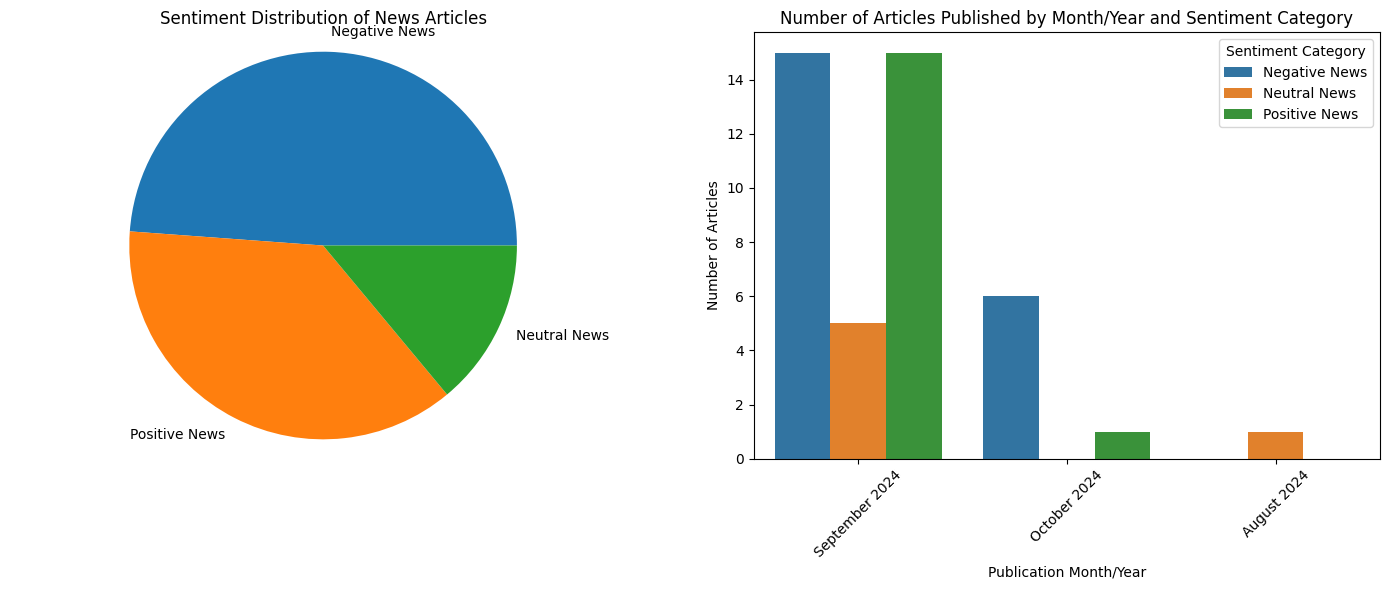

In [122]:
df = pd.DataFrame(articles)

df = df.dropna(subset=['publish_date'])
df['publish_date'] = pd.to_datetime(df['publish_date'])
df['publish_month_year'] = df['publish_date'].dt.month_name() + ' ' + df['publish_date'].dt.year.astype(str)

df['sentiment'] = df['polarity'].apply(categorize_sentiment)
sentiment_counts = df['sentiment'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].pie(sentiment_counts, labels=sentiment_counts.index)
axs[0].axis('equal')
axs[0].set_title('Sentiment Distribution of News Articles')


sns.countplot(data=df, x='publish_month_year', hue='sentiment', order=df['publish_month_year'].value_counts().index, ax=axs[1])
axs[1].set_title('Number of Articles Published by Month/Year and Sentiment Category')
axs[1].set_xlabel('Publication Month/Year')
axs[1].set_ylabel('Number of Articles')
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend(title='Sentiment Category')

plt.tight_layout()
plt.show()